In [10]:
import os 
from ipsl_dataset import IPSL_DCPP
import lightning.pytorch as pl
import torch
import hydra
import numpy as np
from ipsl_dataset import surface_variables
scratch = os.environ['SCRATCH']
work = os.environ['WORK']
run_name = ''
#6 month 
checkpoint_path = f'{work}/ipsl_dcpp/ipsl_dcpp_emulation/6l0y0nym/checkpoints/epoch=4-step=14125.ckpt'
# 2 year
checkpoint_path = f'{work}/ipsl_dcpp/ipsl_dcpp_emulation/0qo4adab/checkpoints/24_month_epoch=04.ckpt'
no_soil_checkpoint_5_year = f'{work}/ipsl_dcpp/ipsl_dcpp_emulation/5ilnejaj/checkpoints/24_month_epoch=07.ckpt'
with_soil_checkpoint_5_year = f'{work}/ipsl_dcpp/ipsl_dcpp_emulation/8tea8aet/checkpoints/24_month_epoch=07.ckpt'

In [2]:
# from hydra import compose, initialize
# from omegaconf import OmegaConf


# with initialize(version_base=None, config_path="conf"):
#     cfg = compose(config_name="config")


In [3]:
checkpoint_no_soil = torch.load(no_soil_checkpoint_5_year,map_location=torch.device('cpu'))
checkpoint_with_soil = torch.load(with_soil_checkpoint_5_year,map_location=torch.device('cpu'))


In [4]:
test = IPSL_DCPP('test',cfg.experiment.lead_time_months)
test_dataloader = torch.utils.data.DataLoader(test,batch_size=1,shuffle=False,num_workers=1)

In [5]:
#checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))

#no_soil_model = hydra.utils.instantiate(cfg.experiment.module,backbone=hydra.utils.instantiate(cfg.experiment.backbone),dataset=test_dataloader.dataset)
soil_model = hydra.utils.instantiate(cfg.experiment.module,backbone=hydra.utils.instantiate(cfg.experiment.backbone),dataset=test_dataloader.dataset)
#no_soil_model.load_state_dict(checkpoint_no_soil['state_dict'])
soil_model.load_state_dict(checkpoint_with_soil['state_dict'])

/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

In [6]:
trainer = pl.Trainer(fast_dev_run=1)
output = trainer.predict(soil_model, test_dataloader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
SLURM auto-requeueing enabled. Setting signal handlers.
/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/lightning

Predicting DataLoader 0: 100%|██████████| 1/1 [00:10<00:00,  0.10it/s]


In [7]:
mean_acc_stacked = []
pred_next_stacked = []
batch_next_stacked = []
for mean_acc,pred_next,batch_next,cur in output:
    mean_acc_stacked.append(mean_acc)
    pred_next_stacked.append(pred_next)
    batch_next_stacked.append(batch_next)

In [24]:
var_index = surface_variables.index('tas')

In [25]:
np.stack(pred_next_stacked).squeeze()[var_index]

276.80637

In [26]:
np.stack(batch_next_stacked).squeeze()[var_index]

277.16013

In [27]:
np.stack(mean_acc_stacked).squeeze()[var_index]

0.99321955

In [17]:
def get_time_series(output,var_index):
    pred_means = []
    batch_means = []
    for i in range(len(output)):
        pred = output[i][0]
        batch = output[i][1]
        pred_means.append(pred[:,var_index].flatten())
        batch_means.append(batch[:,var_index].flatten())
    pred_means = torch.concat(pred_means)
    batch_means = torch.concat(batch_means)
    return pred_means,batch_means

In [24]:
climatology.shape

(12, 135)

121

In [29]:
ps,bs = get_time_series(output,surface_variables.index(var_name))

In [31]:
gpp_climatology = climatology[:,surface_variables.index(var_name)]

In [44]:
def acc(predicted,modeled):
    accuracy = np.sqrt((predicted * modeled) / (np.power(predicted,2) * np.power(modeled,2)))
    return accuracy
    

In [45]:
acc(ps - gpp_climatology,bs - gpp_climatology)

tensor([0.6369, 0.5893, 1.0082, 1.1735, 0.8873, 1.3764, 0.9183, 0.6126, 0.5680,
        0.5719, 0.5765, 0.6221])

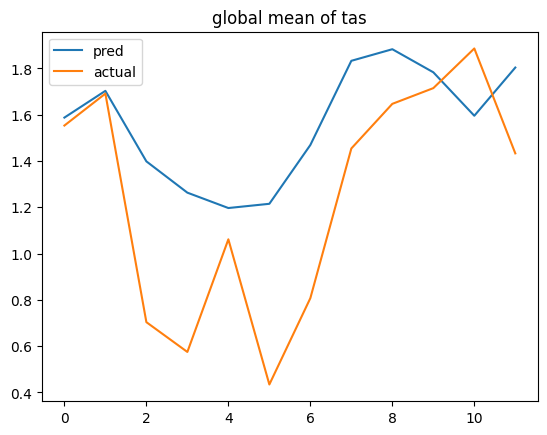

In [33]:
import matplotlib.pyplot as plt
var_name = 'tas'

plt.plot(ps - gpp_climatology,label='pred')
plt.plot(bs - gpp_climatology,label='actual')
# plt.plot(climatology[:,surface_variables.index(var_name)],label='climatology')
plt.title(f'global mean of {var_name}')

plt.legend()
#DOCUMENT THESE RESULTS METHODICALLY 
plt.savefig(f'{work}/{var_name}_plot')

In [20]:
ps

[tensor([277.4683, 277.0538, 277.0034, 277.9909])]

In [8]:
import xarray as xr
ds = xr.open_dataset(test.files[0])
shell = ds.isel(time=0)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

for var in surface_variables:
    var_index = surface_variables.index(var)
    mae = np.abs(batch['next_state_surface'][0][var_index,:,:] - pred['next_state_surface'][0][var_index,:,:]).mean().item()
    print(var,mae)

baresoilFrac 2.8847568035125732
c3PftFrac 3.960676908493042
c4PftFrac 1.302024483680725
cLeaf 0.007261114194989204
cLitter 0.034944549202919006
cLitterAbove 0.02850738726556301
cLitterBelow 0.009802833199501038
cProduct 0.0071585578843951225
cRoot 0.047029878944158554
cSoilFast 0.003399807494133711
cSoilMedium 0.07211760431528091
cSoilSlow 0.1229531541466713
cVeg 0.2235301434993744
cropFrac 1.5729695558547974
mrsos 1.2372705936431885
evspsblsoi 1.4006535593580338e-06
evspsblveg 6.872824087622575e-07
fHarvest 2.5749025134302883e-10
fLitterSoil 4.0955810964860007e-10
fVegLitter 1.2185570330558448e-09
grassFrac 2.5335795879364014
lai 0.11879536509513855
mrfso 15.635823249816895
mrro 5.002853413316188e-06
mrros 2.883471324821585e-06
mrso 24.136722564697266
prveg 6.86908947500342e-07
rGrowth 8.262315831508715e-10
rMaint 9.802102463041251e-10
ra 1.5816261633716522e-09
rh 6.975258148855801e-10
tran 1.340307335340185e-06
treeFrac 2.6291656494140625
treeFracPrimDec 1.7162649631500244
treeFracPr

In [13]:
var_index = surface_variables.index('nep')

In [14]:
import numpy as np

Text(0.5, 1.0, 'tas')

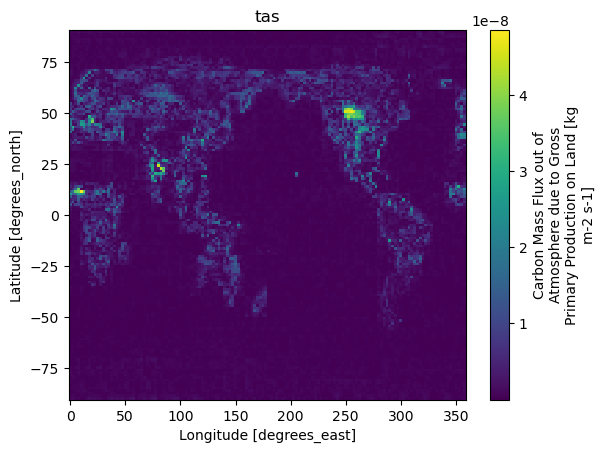

In [16]:
shell['gpp'].data = np.abs(batch['next_state_surface'][0][var_index,:,:] - pred['next_state_surface'][0][var_index,:,:])
shell['gpp'].plot.pcolormesh()
plt.title('tas')


In [17]:
import xarray
import os
store_dir = os.environ['STORE']
year =1960
variation = 1

Lmon =  xarray.open_mfdataset(f'{store_dir}/s{year}-r{variation}i1p1f1/Lmon/*.nc',compat='minimal')



In [19]:
list(Lmon.data_vars)[1:]

['baresoilFrac',
 'c3PftFrac',
 'c4PftFrac',
 'cLeaf',
 'cLitter',
 'cLitterAbove',
 'cLitterBelow',
 'cProduct',
 'cRoot',
 'cSoilFast',
 'cSoilMedium',
 'cSoilSlow',
 'cVeg',
 'cropFrac',
 'depth_bounds',
 'mrsos',
 'evspsblsoi',
 'evspsblveg',
 'fHarvest',
 'fLitterSoil',
 'fVegLitter',
 'gpp',
 'grassFrac',
 'lai',
 'landCoverFrac',
 'mrfso',
 'mrro',
 'mrros',
 'mrso',
 'nbp',
 'npp',
 'nppLeaf',
 'nppRoot',
 'nppWood',
 'prveg',
 'rGrowth',
 'rMaint',
 'ra',
 'residualFrac',
 'rh',
 'tran',
 'treeFrac',
 'treeFracPrimDec',
 'treeFracPrimEver',
 'tsl']

In [11]:
from ipsl_dataset import surface_variables,Amon_variables

In [13]:
[x for x in surface_variables if x not in Amon_variables]

['baresoilFrac',
 'c3PftFrac',
 'c4PftFrac',
 'cLeaf',
 'cLitter',
 'cLitterAbove',
 'cLitterBelow',
 'cProduct',
 'cRoot',
 'cSoilFast',
 'cSoilMedium',
 'cSoilSlow',
 'cVeg',
 'cropFrac',
 'mrsos',
 'evspsblsoi',
 'evspsblveg',
 'fHarvest',
 'fLitterSoil',
 'fVegLitter',
 'grassFrac',
 'lai',
 'mrfso',
 'mrro',
 'mrros',
 'mrso',
 'prveg',
 'rGrowth',
 'rMaint',
 'ra',
 'rh',
 'tran',
 'treeFrac',
 'treeFracPrimDec',
 'treeFracPrimEver',
 'cLand',
 'cLitterGrass',
 'cLitterSubSurf',
 'cLitterSurf',
 'cLitterTree',
 'cMisc',
 'cOther',
 'cSoil',
 'cSoilGrass',
 'cSoilTree',
 'cStem',
 'cVegGrass',
 'cVegTree',
 'cWood',
 'cropFracC3',
 'cropFracC4',
 'evspsblpot',
 'fAnthDisturb',
 'fDeforestToAtmos',
 'fDeforestToProduct',
 'fHarvestToAtmos',
 'fHarvestToProduct',
 'fLuc',
 'fProductDecomp',
 'grassFracC3',
 'grassFracC4',
 'intuadse',
 'intuaw',
 'intvadse',
 'intvaw',
 'mrlso',
 'mrtws',
 'prhmax',
 'raGrass',
 'raTree',
 'rhGrass',
 'rhLitter',
 'rhSoil',
 'rhTree',
 'rls',
 'rss'